# Current TD Portfolio

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

## Fund Summary

In [84]:
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
path = 'C:\\Users\\luoyan011\\Desktop\\PersonalLearning\\GitHub\\private_data'
from IPython.display import Markdown as md
from IPython.display import display, HTML
import xlrd
from yahoo_fin.stock_info import *
from yahoo_fin import stock_info as si

import matplotlib.pyplot as plt
from palettable.colorbrewer.qualitative import Pastel1_7
import altair as alt


In [3]:
# path = os.getcwd()
file = 'stock_smr.xlsx'
sheet = 'holding'
xlsf = pd.ExcelFile(os.path.join(path, file))
stock_smr = pd.read_excel(os.path.join(path,file), sheet_name = sheet)
initial_fund_CAD = 35360.52
initial_fund_USD = 17540.96
current_cash_CAD = stock_smr[(stock_smr.products == 'CASH') & (stock_smr.currency == 'CAD')]['cost']
current_cash_USD = stock_smr[(stock_smr.products == 'CASH') & (stock_smr.currency == 'USD')]['cost']


from datetime import datetime, timedelta
td = str((datetime.today() - timedelta(days = max(1, (datetime.today().weekday() + 6) % 7 - 3))).strftime('%m/%d/%Y'))
lstyear = str((datetime.strptime(td, '%m/%d/%Y') + timedelta(days = -365)).strftime('%m/%d/%Y'))
lstmon = str((datetime.strptime(td, '%m/%d/%Y') + timedelta(days = -90)).strftime('%m/%d/%Y'))
tmr = str((datetime.strptime(td, '%m/%d/%Y') + timedelta(days = 1)).strftime('%m/%d/%Y'))



#stock_tickers = stock_smr[(stock_smr.products == 'STOCK') | (stock_smr.products == 'ETF')]["ticker"].unique()
stock_tickers = stock_smr[stock_smr.products != 'CASH']["ticker"].unique()

df=pd.DataFrame()
for sticker in stock_tickers:
    data = si.get_data(sticker, start_date = lstmon, end_date = tmr)
    df = df.append(data)
df['date'] = df.index
curr_cadusd = pd.to_numeric(si.get_data('CADUSD=X', start_date = td, end_date = tmr).sort_index(ascending=False).head(1).adjclose)[0]

from pandasql import sqldf, load_meat, load_births
pysqldf = lambda q: sqldf(q, globals())

stock_curr_price = df[df.adjclose.notnull()].sort_values(by = ['date'], ascending=False).groupby('ticker').head(3)
stock_curr_price['rank'] = stock_curr_price.groupby('ticker')['date'].rank(method = 'first', ascending = False)

query = """
    SELECT 
        A.*, B.adjclose as today_price, C.adjclose as lastday_price, 
        B.adjclose / A.cost - 1 as today_roe, 
        B.adjclose / C.adjclose - 1 as today_ir,
        round((B.adjclose - A.cost) * A.share) as profit,
        round(case when A.ticker = 'CASH' then A.cost else B.adjclose * A.share end) as curr_value
    FROM 
        stock_smr A
    LEFT JOIN 
        stock_curr_price B on A.ticker = B.ticker and B.rank = 1
    LEFT JOIN 
        stock_curr_price C on A.ticker = C.ticker and C.rank = 2;
    """

stock_curr_smr = pysqldf(query)
display(stock_curr_smr)
stock_curr_smr['currency_index'] = [1 if x == 'CAD' else curr_cadusd for x in stock_curr_smr['currency']]
stock_curr_smr['curr_value_CAD'] = stock_curr_smr.curr_value / stock_curr_smr.currency_index

profit_CAD = round(stock_curr_smr[stock_curr_smr.category != 'CASH'][stock_curr_smr.currency == 'CAD']['profit'].sum())
profit_USD = round(stock_curr_smr[stock_curr_smr.category != 'CASH'][stock_curr_smr.currency == 'USD']['profit'].sum())
curr_fund_CAD = round(profit_CAD + initial_fund_CAD)
curr_fund_USD = round(profit_USD + initial_fund_USD)
total_curr_fund_CAD = curr_fund_CAD + round(curr_fund_USD / curr_cadusd)
total_ini_fund_CAD = round(initial_fund_CAD + initial_fund_USD / curr_cadusd)
cash_CAD = round(stock_curr_smr[stock_curr_smr.category == 'CASH'][stock_curr_smr.currency == 'CAD']['cost'].sum())
cash_USD = round(stock_curr_smr[stock_curr_smr.category == 'CASH'][stock_curr_smr.currency == 'USD']['cost'].sum())
investment_CAD = curr_fund_CAD - cash_CAD
investment_USD = curr_fund_USD - cash_USD
ivt_CAD_pct = (investment_CAD / curr_fund_CAD)
ivt_USD_pct = (investment_USD / curr_fund_USD)
ivt_pct = ((investment_CAD + investment_USD / curr_cadusd) / total_curr_fund_CAD)
inv_roc_CAD = profit_CAD / investment_CAD
inv_roc_USD = profit_USD / investment_USD
inv_roc_total = (profit_CAD + profit_USD / curr_cadusd) / (investment_CAD + investment_USD / curr_cadusd)



,ticker,share,cost,category,currency,products,today_price,lastday_price,today_roe,today_ir,profit,curr_value
0,HUZ.TO,250.00,12.37,SILVER,CAD,ETF,12.710000,12.560000,0.027486,0.011943,85.0,3178.0
1,0P00016N6T.TO,109.17,36.64,IT,CAD,MUTUAL,36.730000,37.340000,0.002456,-0.016336,10.0,4010.0
2,HZU.TO,90.00,23.41,SILVER,CAD,ETF,17.850000,17.309999,-0.237505,0.031196,-500.0,1607.0
3,VDE,57.00,51.82,OIL,USD,ETF,77.260002,75.889999,0.490930,0.018052,1450.0,4404.0
4,HGU.TO,75.00,32.54,GOLD,CAD,ETF,17.280001,16.950001,-0.468961,0.019469,-1144.0,1296.0
5,ENB.TO,80.00,36.12,OIL,CAD,STOCK,49.630001,49.400002,0.374031,0.004656,1081.0,3970.0
6,CASH,0.00,26798.00,CASH,CAD,CASH,NaN,NaN,NaN,NaN,NaN,26798.0
7,CASH,0.00,17208.00,CASH,USD,CASH,NaN,NaN,NaN,NaN,NaN,17208.0
8,SPCE,70.00,16.94,SPACE,USD,STOCK,43.189999,46.000000,1.549587,-0.061087,1837.0,3023.0


In [28]:
print("Initial CAD fund: ", initial_fund_CAD, ". Initial USD fund: ", initial_fund_USD, 
      "\nCurrent CAD fund: ", curr_fund_CAD, ". Current USD fund:", curr_fund_USD,
      "\nTotal profit in CAD: ", profit_CAD, ". Total profit in USD: ", profit_USD,
      "\nROC in CAD: ", "{:.1%}".format(inv_roc_CAD), ". ROC in USD: ", "{:.1%}".format(inv_roc_USD), ". ROC overall: ", "{:.1%}".format(inv_roc_total),
      "\nCurrent cash in CAD: ", cash_CAD, ". Current cash in USD: ", cash_USD,
      "\nCurrent investment in CAD: ", investment_CAD, ".Current investment in USD: ", investment_USD,
     "\nInitial fund in CAD: ", total_ini_fund_CAD, ". Current fund in CAD: ", total_curr_fund_CAD,
     "\nInvestment % in CAD: ", "{:.1%}".format(ivt_CAD_pct), ". Investment % in USD: ", "{:.1%}".format(ivt_USD_pct), ". Investment % total: ", "{:.1%}".format(ivt_pct))



Initial CAD fund:  35360.52 . Initial USD fund:  17540.96 
Current CAD fund:  34893 . Current USD fund: 20828 
Total profit in CAD:  -468 . Total profit in USD:  3287 
ROC in CAD:  -5.8% . ROC in USD:  90.8% . ROC overall:  28.7% 
Current cash in CAD:  26798 . Current cash in USD:  17208 
Current investment in CAD:  8095 .Current investment in USD:  3620 
Initial fund in CAD:  57183 . Current fund in CAD:  60804 
Investment % in CAD:  23.2% . Investment % in USD:  17.4% . Investment % total:  20.7%


## Fund Category Distribution

,curr_value_CAD
category,
CASH,48206.0
GOLD,1296.0
IT,4010.0
OIL,9449.0
SILVER,4785.0
SPACE,3761.0


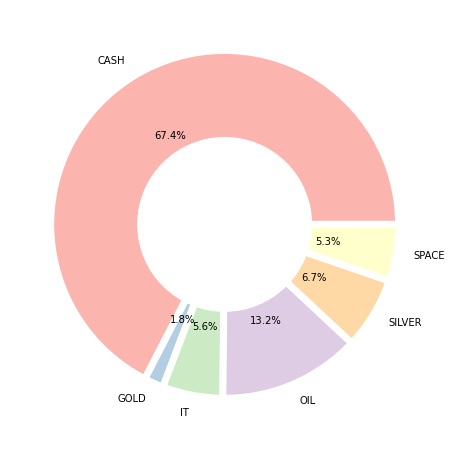

In [29]:
import matplotlib.pyplot as plt

category_data_smr = pd.DataFrame(stock_curr_smr.groupby('category')['curr_value_CAD'].agg('sum').round(0))
display(HTML(category_data_smr.to_html()))

category_data_smr['category'] = category_data_smr.index

my_circle=plt.Circle( (0,0), 0.5, color='white')
# plot link: https://python-graph-gallery.com/161-custom-matplotlib-donut-plot/
from palettable.colorbrewer.qualitative import Pastel1_7
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(aspect="equal"))
plt.pie(category_data_smr.curr_value_CAD, 
        labels=category_data_smr.category, 
        colors=Pastel1_7.hex_colors, 
        autopct='%1.1f%%',
        wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' })
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()


## Fund Products Distribution

,curr_value_CAD
products,
CASH,48205.956868
ETF,11559.884359
MUTUAL,4010.000000
STOCK,7730.823664


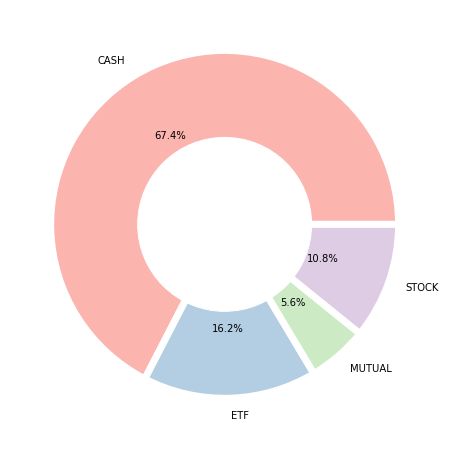

In [30]:
product_data_smr = pd.DataFrame(stock_curr_smr.groupby('products')['curr_value_CAD'].agg('sum'))
display(HTML(product_data_smr.to_html()))
product_data_smr['products'] = product_data_smr.index

my_circle=plt.Circle( (0,0), 0.5, color='white')
# plot link: https://python-graph-gallery.com/161-custom-matplotlib-donut-plot/
from palettable.colorbrewer.qualitative import Pastel1_7
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(aspect="equal"))
plt.pie(product_data_smr.curr_value_CAD, 
        labels=product_data_smr.products, 
        colors=Pastel1_7.hex_colors, 
        autopct='%1.1f%%',
        wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' })
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

## Current Holding Market Watch

In [14]:
# generate plots: volume analysis
import altair as alt
alt.Chart(df).mark_line().encode(x='date',y='volume', column = 'ticker')
alt.Chart(df).mark_line().encode(x='date',y='volume', color = 'ticker:N')


alt.Chart(...)

ticker
0P00016N6T.TO    AxesSubplot(0.125,0.2;0.775x0.68)
ENB.TO           AxesSubplot(0.125,0.2;0.775x0.68)
HGU.TO           AxesSubplot(0.125,0.2;0.775x0.68)
HUZ.TO           AxesSubplot(0.125,0.2;0.775x0.68)
HZU.TO           AxesSubplot(0.125,0.2;0.775x0.68)
SPCE             AxesSubplot(0.125,0.2;0.775x0.68)
VDE              AxesSubplot(0.125,0.2;0.775x0.68)
Name: volume, dtype: object

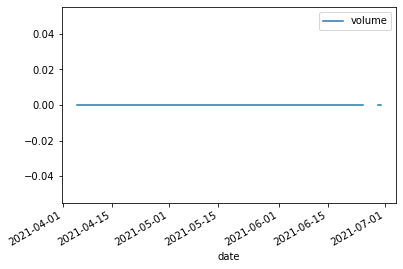

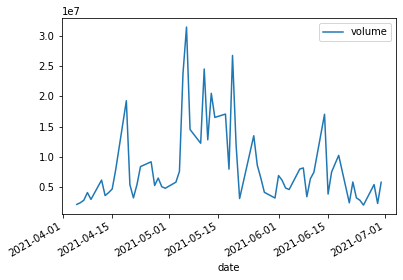

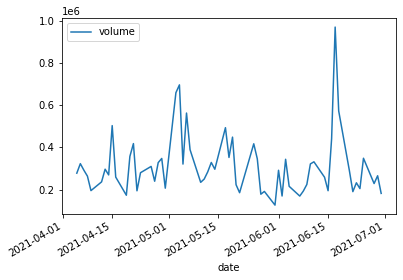

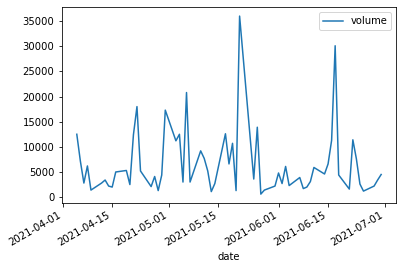

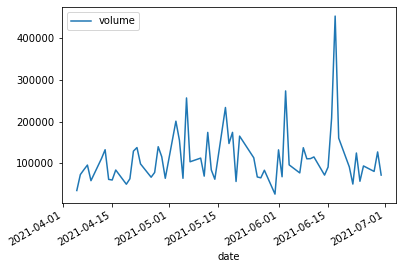

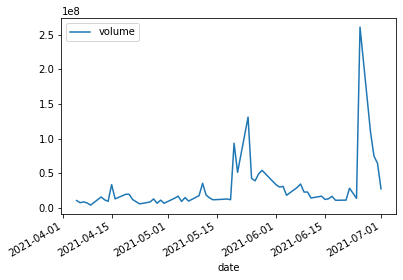

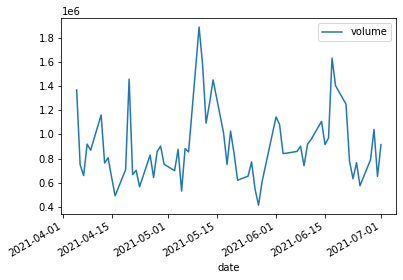

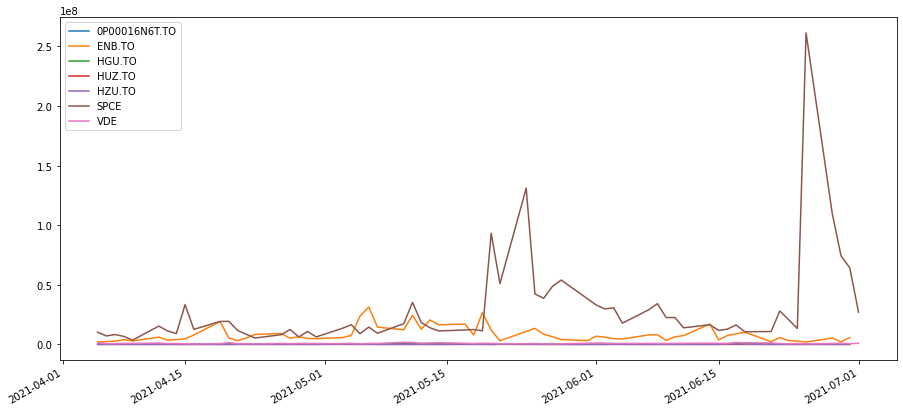

In [16]:
import matplotlib.pyplot as plt

df.groupby('ticker').plot(x = 'date', y = 'volume')

fig, ax = plt.subplots(figsize=(15,7))
df.groupby('ticker')['volume'].plot(legend=True)


## Watch List

In [82]:
watchlist = pd.read_excel(os.path.join(path,file), sheet_name = 'watchlist')
watchlist_ticker = watchlist["ticker"].unique()
watchlist_df=pd.DataFrame()
for sticker in watchlist_ticker:
    watchlist_df = watchlist_df.append(si.get_data(sticker, start_date = lstyear, end_date = tmr))
watchlist_df['date'] = watchlist_df.index
watchlist_df.head(3)

,open,high,low,close,adjclose,volume,ticker,date
2020-07-01,16.980000,17.350000,16.430000,16.520000,16.513342,3782500,JETS,2020-07-01
2020-07-02,17.000000,17.094999,16.549999,16.590000,16.583313,3068500,JETS,2020-07-02
2020-07-06,16.959999,17.100000,16.540001,16.959999,16.953163,3004600,JETS,2020-07-06


In [85]:
alt.Chart(watchlist_df).mark_line().encode(x='date',y='volume', color = 'ticker:N')


alt.Chart(...)

In [97]:
import yahooquery
from yahooquery import Ticker

def get_etf_holding(ticker):
    t = Ticker(ticker)
    print('===============================',ticker,'=================================')
    print()
    print('-------------------------- Key Factor ----------------------------')
    print(pd.DataFrame(t.key_stats[ticker], index=[0]).T.set_axis(['Value'], axis=1, inplace=False))
    print('-------------------------- Fund Sector ----------------------------')
    fund_sector = t.fund_sector_weightings
    if len(fund_sector) >1:
        fund_sector.insert(0,'Fund Sector',fund_sector.index)
        fund_sector = fund_sector.reset_index(drop=True)
        fund_sector.columns = ['Fund Sector','Percentage']
        fund_sector = fund_sector.sort_values(by='Percentage', ascending=False)
    print(fund_sector)
    print('-------------------------- Holdings ----------------------------')
    if type(t.fund_holding_info[ticker]) != str:
        print(pd.DataFrame(t.fund_holding_info[ticker]['holdings']))
    print('-------------------------- Returns ----------------------------')
    if type(t.fund_performance[ticker]) != str:
        print(pd.DataFrame(t.fund_performance[ticker]['performanceOverview'], index=[0]).T.set_axis(['Value'], axis=1, inplace=False))
        print()
        print(pd.DataFrame(t.fund_performance[ticker]['trailingReturns'], index=[0]).T.set_axis(['Value'], axis=1, inplace=False))
        print()
        print(pd.DataFrame(t.fund_performance[ticker]['annualTotalReturns']['returns']))
    print('-------------------------- Risk Factors ----------------------------')
    if type(t.fund_performance[ticker]) != str:
        print(pd.DataFrame(t.fund_performance[ticker]['riskOverviewStatistics']['riskStatistics']))
    print('=========================================================================')
 
for i in watchlist_ticker:
    get_etf_holding(i)

=============================== JETS =================================

-------------------------- Key Factor ----------------------------
                                        Value
maxAge                                      1
priceHint                                   2
category                 Miscellaneous Sector
ytdReturn                              0.0824
beta3Year                                1.82
totalAssets                        3974785024
yield                                       0
fundFamily              U.S. Global Investors
fundInceptionDate         2015-04-29 20:00:00
legalType                Exchange Traded Fund
threeYearAverageReturn                -0.0517
fiveYearAverageReturn                  0.0352
lastSplitFactor                          None
-------------------------- Fund Sector ----------------------------
               Fund Sector  Percentage
8              industrials       0.991
4               technology       0.009
0               realestate      

In [98]:
get_etf_holding('0P00016N6T.TO')


=============================== 0P00016N6T.TO =================================

-------------------------- Key Factor ----------------------------
                                        Value
maxAge                                      1
priceHint                                   2
morningStarOverallRating                    0
morningStarRiskRating                       0
category                                 None
annualReportExpenseRatio               0.0199
beta3Year                                1.24
totalAssets                        1851359872
fundFamily                               None
fundInceptionDate         2015-10-19 20:00:00
legalType                                None
lastSplitFactor                          None
annualHoldingsTurnover                 0.7489
-------------------------- Fund Sector ----------------------------
               Fund Sector  Percentage
4               technology      0.5880
5   communication_services      0.1770
1        consumer_cycli